# Proyecto Final: "Predicción de precios de autos usados en Reino Unido"

**Objetivo**: Desarrollar un modelo que nos prediga el precio de los autos usados en RU, primero para A) Volkswagen y despues para B) Audy con los base de datos ["100,000 UK Used Car Data set"](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes) obtenida en kaggle.

**Variables**: Las variables que tenemos en la base de datos son:

1. *model.-* Modelo del automóvil
2. *year.-* Año de salida del automóvil
3. *transmission.-* Tipo de transmión: Automatic, Manual y Semiautomatic
4. *mileage.-* Kilometraje del vehiculo
5. *fuelType.-* Tipo de combustible: Petrol, Diesel, Hybrid y Other
6. *tax.-*  Impuesto del automóvil
7. *mpg.-* Millas por galon (miles per galon)
8. *engineSize.-* Tamaño del motor
9. *price.-* Precio del automóvil

Primero, importemos las librerias que usaremos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import glob
import os
import re
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Seleccion de variables
from sklearn.feature_selection import SelectKBest, f_regression

# Métricas de evaluación
from sklearn.metrics import (r2_score, mean_squared_error)

Se carga los archivos de la base de datos

In [2]:
# archivos = ['cclass','focus','audi','bmw','ford','hyundi','merc','skoda', 'toyota', 'vauxhall', 'vw']
archivos = ['audi', 'vw']

li = []

for i in archivos:
    path = r"Datos\%s" %(i)  # ruta de la carpeta de archivos
    all_files = glob.glob(path + "*.csv")  # tipo de archivo que tiene la carpeta
#     print(path)
#     print(all_files)
    for filename in all_files:
        df = pd.read_csv(filename,  engine='python')# sep='\\t'
        df['Company']=str(i)
        
        print('Se cargo', df['Company'][0])
        print('Total de columnas:',len(df.columns))
        print('------------------------')
#         print(df.isnull().sum())
        li.append(df)
        

Se cargo audi
Total de columnas: 10
------------------------
Se cargo vw
Total de columnas: 10
------------------------


### Funciones

Se declara las funciones que utilizaremos

In [3]:
def desc_inicial(data):
    """
    Da los valores nulos y dimensiones del dataframe
    """
    print('Sus dimensiones son:',data.shape[0],'renglones y',data.shape[1],'columnas.')
    print('-----------------------------')
    print('Los valores nulos son:')
    return(data.isnull().sum())

In [4]:
def columna_intervalo(dataframe, columna, intervalo):
    """
    Crea una nueva columna, tomando los datos de 'columna' y haciendo intervalos de tamaño 'intervalo'
    dataframe[new_column]=columna_intervalo(dataframe, columna, intervalo)
    """
    max_ = dataframe[columna].max()
    min_ = dataframe[columna].min()
    
    labels = ["{0} - {1}".format(i, i+intervalo) for i in range(min_,max_,intervalo)]
    return(pd.cut(dataframe[columna].values, range(min_,max_+intervalo,intervalo), right=True, labels=labels))

In [5]:
def countplot_values(data,column,size):
    """
    Da un countplot de una variable (column) con sus valores absolutos y porcentuales en el grafico
    """
    sbn.countplot(data[column], order = data[column].value_counts().index)
    
    # Etiquetas para countplot vertical
    total_col = data[column].value_counts().sum()
    max_val = max(data[column].value_counts())
    
    for i, j in enumerate((data[column].value_counts())):
    #     print(i,j)
#         plt.text(i, 1.01*j, "%d, " % j, fontsize=size, ha='right'); # ha -> posicion de la etiqueta
#         plt.text(i, 1.01*j, "%.2f%%" % round(j/total_col*100,2), fontsize=size,  ha='left');
    
        plt.text(i, j+0.01*max_val, "%.2f%%" % round(j/total_col*100,2), fontsize=size, ha = 'center');

In [6]:
def countplot_values_horizontal(data,column,size):
    """
    Da un countplot horizontal de una variable (column) con sus valores porcentuales en el grafico
    """

    ax = sbn.countplot(y = data[column], order = data[column].value_counts().index)
        
    total_col = data[column].value_counts().sum()
    max_val = max(data[column].value_counts())
    mean_val = data[column].value_counts().mean()

    ax.set_xlim([0,1.2*max_val])
    for i, j in enumerate((data[column].value_counts())):
    #     print(j,i)
#         plt.text(j+0.6*mean_val, i+0.4, "%d, " % j, fontsize=size,ha='right'); # ha -> posicion de la etiqueta
#         plt.text(j+0.6*mean_val, i+0.4, "%.2f%%" % round(j/total_col*100,2), fontsize=size, ha='left')

        plt.text(j+0.1*max_val, i+0.4, "%d, " % j, fontsize=size,ha='right'); # ha -> posicion de la etiqueta
        plt.text(j+0.1*max_val, i+0.4, "%.2f%%" % round(j/total_col*100,2), fontsize=size, ha='left')

# Para la compañía Volkswagen 

### Cargamos el archivo de la marca Volkswagen (vw) 

In [7]:
data_vw = li[-1]

data_vw[:5]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0,vw
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0,vw
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0,vw
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0,vw
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5,vw


In [8]:
desc_inicial(data_vw)

Sus dimensiones son: 15157 renglones y 10 columnas.
-----------------------------
Los valores nulos son:


model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
Company         0
dtype: int64

No hay valores nulos, por lo que se puede seguir con la descripción  

### Creación de variables nuevas

1. Se crea la columna **'Age'**, que es la antigüedad del automóvil, se obtiene al restar el año en que obtuvo los datos a 'year'

In [9]:
data_vw['Age'] = 2020 - data_vw['year']
data_vw.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company,Age
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0,vw,1
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0,vw,1
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0,vw,1
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0,vw,1
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5,vw,1


## Parte 1:  Analisis exploratorio

Hagamos pairplot para ver las relaciones entre variables

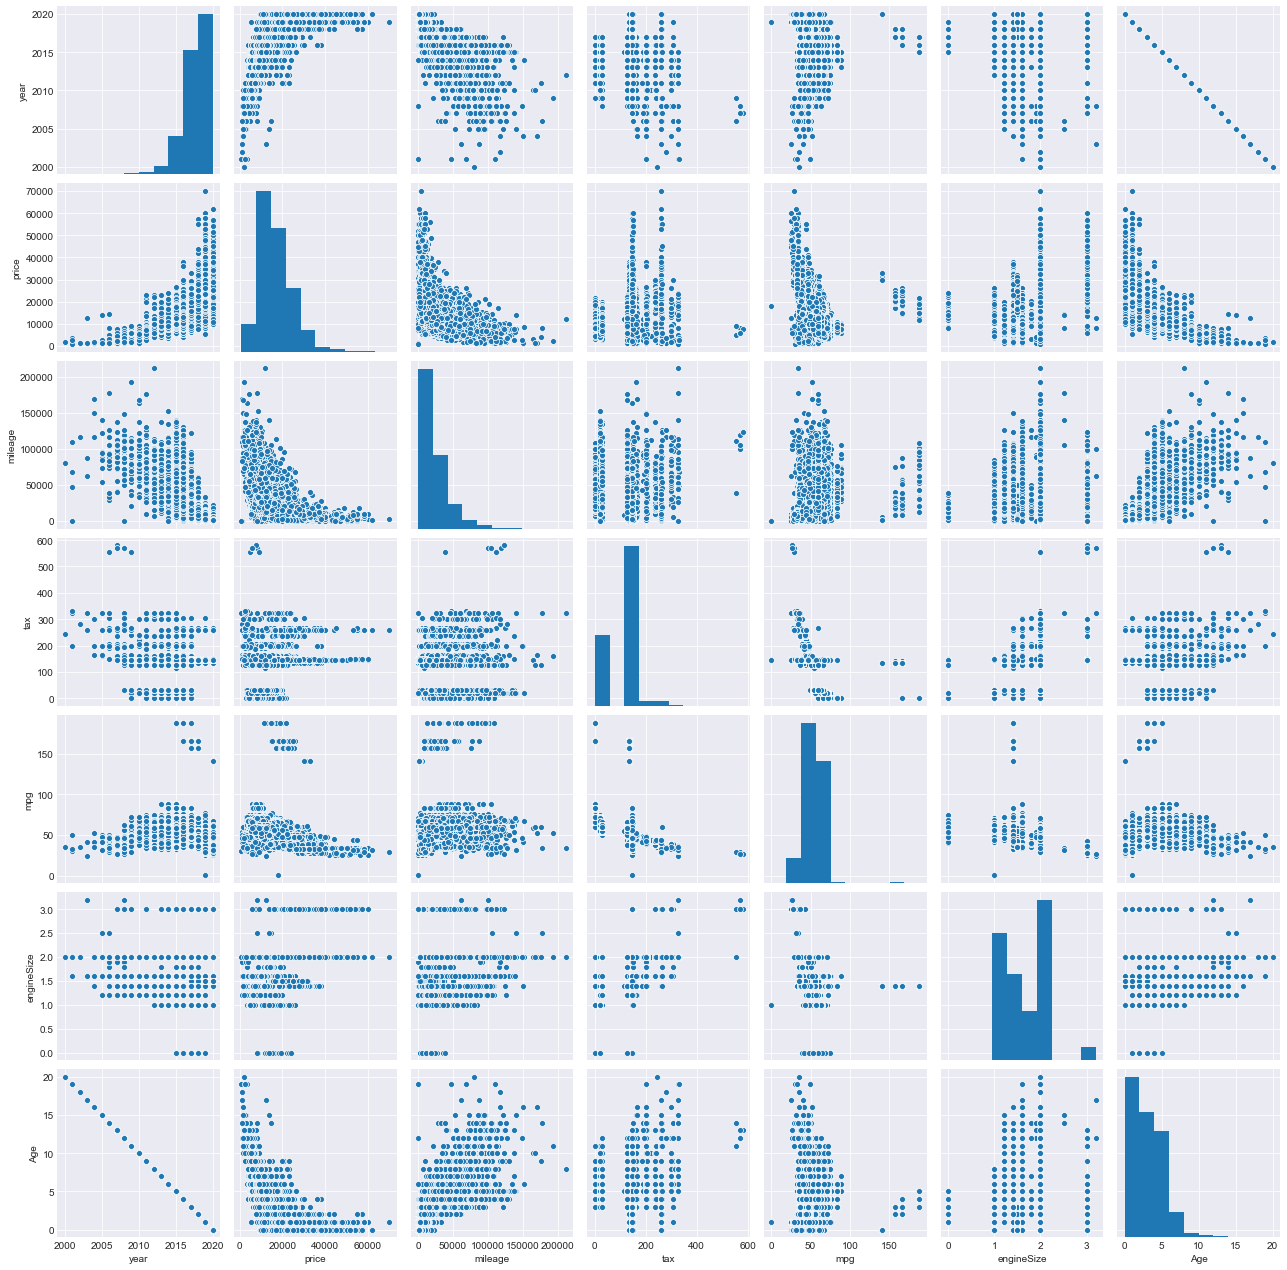

In [10]:
plt.style.use('seaborn-darkgrid')#dark_background, seaborn-dark
sbn.pairplot(data_vw);

Se observa que hay una fuerte relacion entre el 'precio' (objetivo) y las variables predictoras 'year' y 'mileage'

Se hace el histograma de precios

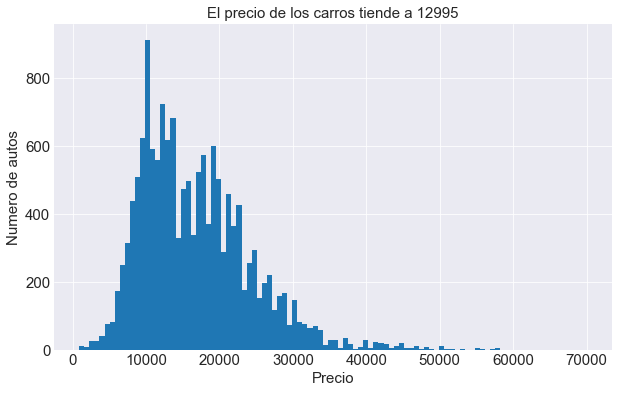

In [20]:
plt.figure(figsize = (10,6))

data_vw['price'].hist(bins = 100)
plt.title('El precio de los carros tiende a %s' % data_vw['price'].mode()[0], fontsize = 15)
# plt.title('El precio de los carros tiende a 10 mil',fontsize = 18)

# plt.xlim(0 , data_vw['price'].quantile(0.99));
plt.xlabel('Precio', fontsize = 15)
plt.ylabel('Numero de autos', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

Se observa que hay autos con precios muy elevados, posiblemente sean **outliers**, por lo que revisaremos su relación con otras variables para detectarlos

### Precio vs Year

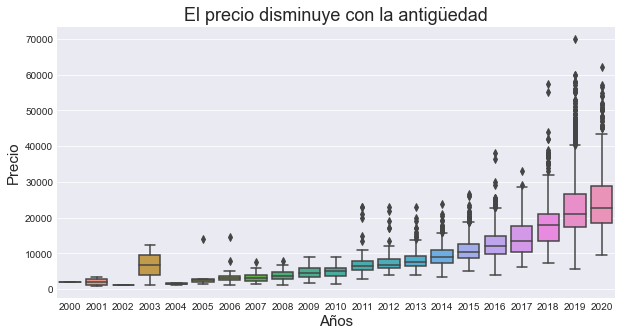

In [12]:
plt.figure(figsize = (10,5))

# sbn.set(style="darkgrid")
sbn.boxplot(x = data_vw['year'], y = data_vw['price'])

plt.title('El precio disminuye con la antigüedad', fontsize = 18)
plt.xlabel('Años', fontsize = 15)
plt.ylabel('Precio', fontsize = 15)
plt.xticks(rotation= 0);

Despues se hace un conteo de autos por año

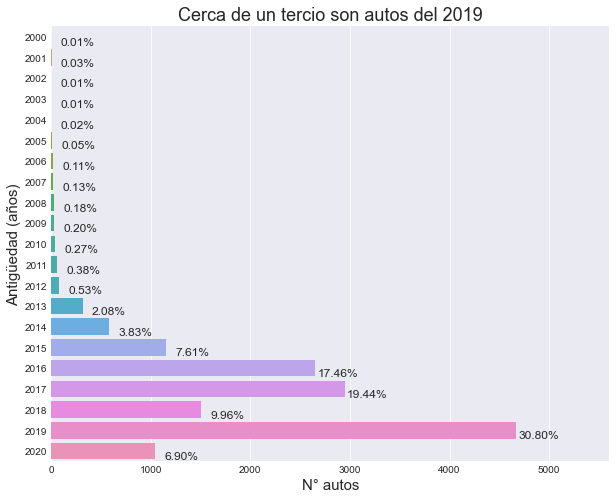

In [21]:
plt.figure(figsize = (10,8))

data = data_vw
column = 'year'
size = 12

ax = sbn.countplot(y = data[column])#, order = data[column].value_counts().index)
        
total_col = data[column].value_counts().sum()
max_val = max(data[column].value_counts())
mean_val = data[column].value_counts().mean()
ax.set_xlim([0,1.2*max_val])

for i, j in enumerate((data.groupby(column).count()['model'])):
#     plt.text(j+0.6*mean_val, i+0.4, "%d, " % j, fontsize=size,ha='right'); # ha -> posicion de la etiqueta
    plt.text(j+0.6*mean_val, i+0.4, "%.2f%%" % round(j/total_col*100,2), fontsize=size,  ha='right')# ha='left')


plt.title('Cerca de un tercio son autos del 2019', fontsize = 18)
plt.ylabel('Antigüedad (años)', fontsize = 15)
plt.xlabel('N° autos', fontsize = 15);

Se revisa cuantos autos tenemos por modelo 

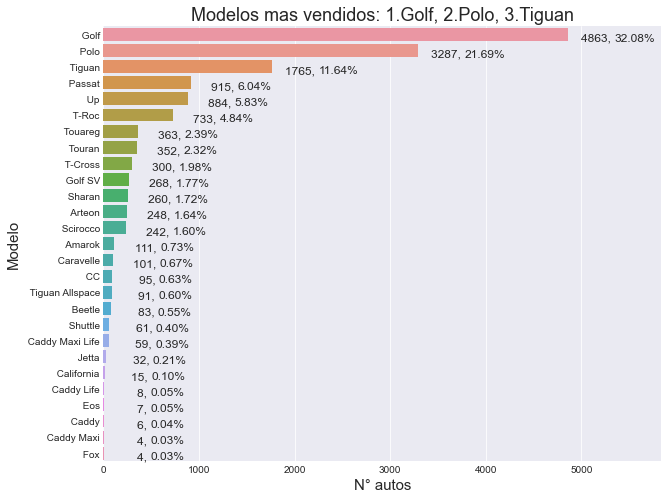

In [22]:
plt.figure(figsize = (10,8))

countplot_values_horizontal(data_vw,"model",12)

plt.title('Modelos mas vendidos: 1.Golf, 2.Polo, 3.Tiguan', fontsize = 18)
plt.ylabel('Modelo', fontsize = 15)
plt.xlabel('N° autos', fontsize = 15);

Se revisa la relación con 'Mileage'

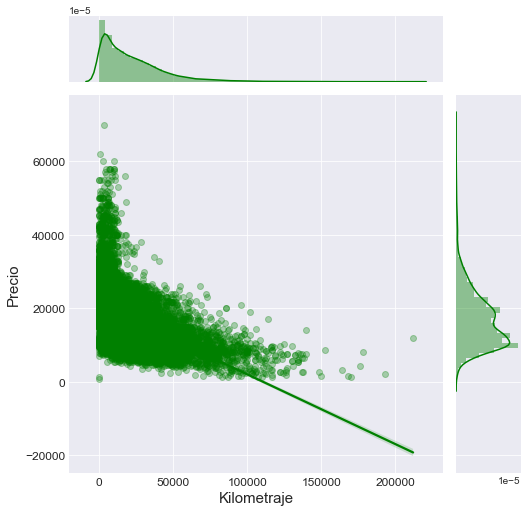

In [15]:
sbn.jointplot(data_vw['mileage'], data_vw['price'], kind = 'reg', 
              color = 'g', height = 7, 
              scatter_kws=dict(alpha=0.3))

plt.xlabel('Kilometraje', fontsize = 15)
plt.ylabel('Precio', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

Se identifica el outlier, tiene un precio alto considerando que tiene un gran kilometraje

In [23]:
data_vw[(data_vw['mileage']>200000)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company,Age
13489,Caravelle,2012,11995,Semi-Auto,212000,Diesel,325,34.4,2.0,vw,8


Se quita el outlier del dataframe y se gráfica para confirmar que se haya eliminado

In [24]:
data_vw = data_vw.drop(data_vw[(data_vw['mileage']> 200000)].index).reset_index(drop = True) 

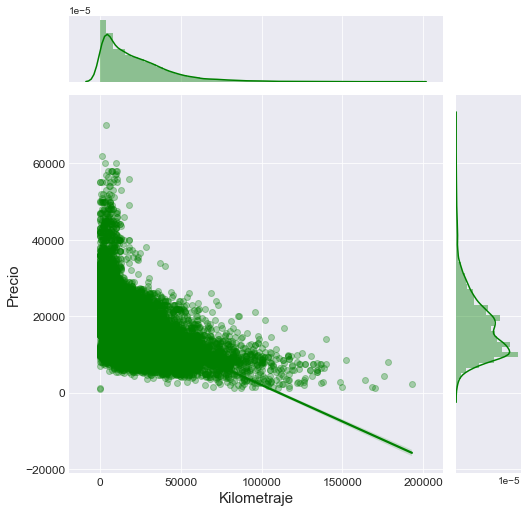

In [25]:
sbn.jointplot(data_vw['mileage'], data_vw['price'], kind = 'reg', 
              color = 'g', height = 7, 
              scatter_kws=dict(alpha=0.3))

plt.xlabel('Kilometraje', fontsize = 15)
plt.ylabel('Precio', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

Existen precios muy elevados:

In [26]:
data_vw[(data_vw['price']> data_vw['price'].quantile(0.999))]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company,Age
13433,Caravelle,2019,56000,Automatic,10500,Diesel,145,33.6,2.0,vw,1
13560,Touareg,2019,59995,Semi-Auto,2980,Petrol,145,25.5,3.0,vw,1
13753,Touareg,2019,59990,Semi-Auto,9950,Diesel,150,34.0,3.0,vw,1
13755,Touareg,2018,57295,Automatic,10000,Diesel,145,34.0,3.0,vw,2
13769,Touareg,2020,56499,Semi-Auto,5000,Petrol,150,25.5,3.0,vw,0
13800,Touareg,2020,56989,Automatic,3895,Diesel,150,33.6,3.0,vw,0
15112,California,2019,55999,Automatic,8783,Diesel,260,32.1,2.0,vw,1
15113,California,2019,56995,Semi-Auto,8991,Diesel,260,33.2,2.0,vw,1
15116,California,2020,61995,Semi-Auto,1000,Diesel,260,32.1,2.0,vw,0
15118,California,2019,69994,Semi-Auto,3544,Diesel,260,29.1,2.0,vw,1


Pero la mayoría corresponde al modelo "California", que es una camoineta tipo Van, cuyo costo oscila entre 45 000 y 75 000, por lo que no los tomare como outliers 

<img src="vw_california.JPG" width="400">

A continuación, se revisa las variables tipo de transmisión y de combustible:

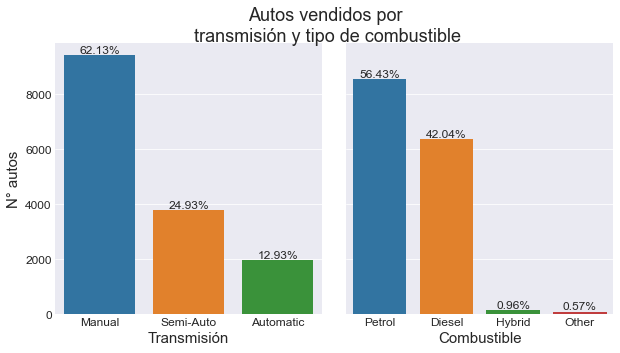

In [29]:
plt.figure(figsize = (10,5))
plt.suptitle('Autos vendidos por\n transmisión y tipo de combustible', fontsize= 18)

#-------------------------------
ax1 = plt.subplot2grid(shape=(1,4), loc=(0,0), colspan=2)

countplot_values(data_vw,"transmission",12)
    
plt.title('',fontsize= 16)
plt.xlabel('Transmisión',fontsize= 15)
plt.ylabel('N° autos', fontsize= 15)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)

#----------------------------------------
ax2 = plt.subplot2grid((1,4), (0,2), colspan=2, sharey = ax1)

countplot_values(data_vw,"fuelType",12)

# Poner titulo, nombres de ejes,    
plt.title('',fontsize= 16)
plt.xlabel('Combustible',fontsize= 15)
plt.ylabel('', fontsize= 15)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12);

for label2 in ax2.get_yticklabels():
    label2.set_visible(False)

plt.show()

Por ultimo revisemos las correlaciones:

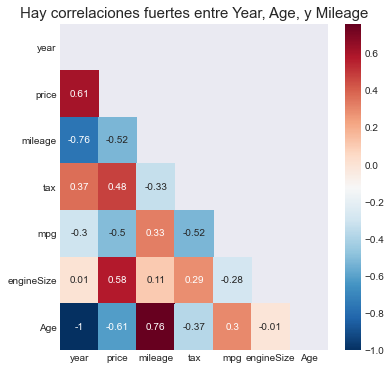

In [30]:
corr = data_vw.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(6,6));
plt.title('Hay correlaciones fuertes entre Year, Age, y Mileage', fontsize = 15)

sbn.heatmap(corr.round(decimals=2), annot= True, cmap = "RdBu_r", mask = mask);

Es obvio que 'year' y 'Age' estan anticorrelacionadas, ya que 'Age' se genero a partir de la primera variable.

### No tomare en cuenta  'year' para el analisis

## Parte 2:  Modelación

Se identifico las variables categóricas, numéricas y la variable objetivo de la database 

In [22]:
print(data_vw.columns)
data_vw[:5]

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize', 'Company', 'Age'],
      dtype='object')


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company,Age
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0,vw,1
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0,vw,1
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0,vw,1
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0,vw,1
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5,vw,1


In [23]:
data_vw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15156 entries, 0 to 15155
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         15156 non-null  object 
 1   year          15156 non-null  int64  
 2   price         15156 non-null  int64  
 3   transmission  15156 non-null  object 
 4   mileage       15156 non-null  int64  
 5   fuelType      15156 non-null  object 
 6   tax           15156 non-null  int64  
 7   mpg           15156 non-null  float64
 8   engineSize    15156 non-null  float64
 9   Company       15156 non-null  object 
 10  Age           15156 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.3+ MB


Se encuentra que el tipo de datos que tienen las variables categoricas son 'object', mientras que las numéricas son 'int'o'float', por lo se puede proseguir

In [31]:
cat = ['model', 'transmission','fuelType']
num = ['mileage', 'tax','mpg', 'engineSize', 'Age']
target = ['price']

 Se trabaja con las variables categóricas y se declara las variables numericas

In [32]:
categories = pd.get_dummies(data_vw[cat], drop_first = True)
numeric = data_vw[num];

Se divide los datos en train y test

In [33]:
predictoras = pd.concat([numeric, categories], axis=1)
objetivo = data_vw['price']

x_train, x_test, y_train, y_test = train_test_split(predictoras, 
                                                    objetivo, test_size=0.2, random_state = 69)

## Regresión Lineal

Se estandariza las variables numericas y se declara las categóricas del entrenamiento

In [34]:
x_num = (x_train[num]-x_train[num].mean())/(x_train[num].std())
x_num.head()

,mileage,tax,mpg,engineSize,Age
12400,-1.038530,0.515772,0.037372,-1.292764,-0.849863
1521,0.400082,-1.471852,0.992141,0.866830,0.129208
849,-0.086168,0.515772,-0.491423,0.866830,0.129208
3594,-0.925075,0.515772,0.661644,0.866830,-0.849863
9841,-0.673724,0.515772,0.558822,-1.292764,-0.360328


In [35]:
x_cat = x_train[list(categories.columns)]
# list(categories.columns)
x_cat.head()

,model_ Arteon,model_ Beetle,model_ CC,model_ Caddy,model_ Caddy Life,model_ Caddy Maxi,model_ Caddy Maxi Life,model_ California,model_ Caravelle,model_ Eos,...,model_ Tiguan,model_ Tiguan Allspace,model_ Touareg,model_ Touran,model_ Up,transmission_Manual,transmission_Semi-Auto,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
12400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
1521,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3594,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Unimos los dos tablas para obtener los datos de entrenamiento estandarizado:

In [36]:
x_train_std = pd.concat([x_num, x_cat], axis=1)

Se hace lo mismo para conjunto de prueba

In [37]:
X_num = (x_test[num]-x_test[num].mean())/(x_test[num].std())
X_cat = x_test[list(categories.columns)]
x_test_std = pd.concat([X_num, X_cat], axis=1)

Ya estandarizada ambas partes, se procede a entrenar el modelo

In [38]:
regressor = LinearRegression()
regressor.fit(x_train_std, y_train)

y_pred_lr = regressor.predict(x_test_std)

Revisemos el performance del modelo

In [40]:
print("Raíz del error cuadrático medio para Volkswagen:", round(np.sqrt(mean_squared_error(y_test,y_pred_lr)),2))

err =np.sqrt(mean_squared_error(y_test,y_pred_lr))/ data_vw['price'].median() *100
print('------------------------------------------------------')
print('Teniendo en cuenta que la mediana del precio es de',round(data_vw['price'].median(),2),',')
print('el error del modelo es del',round(err,2),'% respecto a la mediana.')

Raíz del error cuadrático medio para Volkswagen: 2617.89
------------------------------------------------------
Teniendo en cuenta que la mediana del precio es de 15497.0 ,
el error del modelo es del 16.89 % respecto a la mediana.


In [41]:
print("Su métrica R*2 es: %1.4f" % r2_score(y_test,y_pred_lr))
print('------------------------------------------------------')
print('El resultado de esta métrica es buena, pero se puede mejorar el rendimiento')

Su métrica R*2 es: 0.8863
------------------------------------------------------
El resultado de esta métrica es buena, pero se puede mejorar el rendimiento


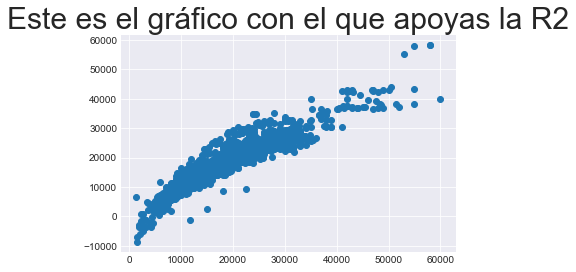

In [42]:
plt.scatter(y_test,y_pred_lr)
plt.title('Este es el gráfico con el que apoyas la R2', fontsize = 30);

# SI TE DAS CUENTA LA TENDENCIA ES CURVA Y HAY UN VALOR TOPE (SALVO ALGUNOS OUTLIERS) DE CUÁNTO PUEDE COSTAR UN COCHE

Error porcentual promedio 13.13 %


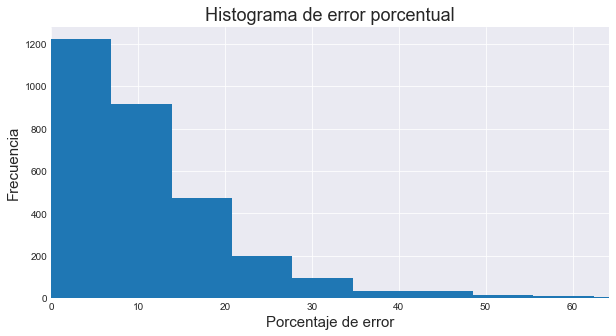

In [43]:
res = abs((y_test - y_pred_lr)/y_test) * 100

plt.figure(figsize = (10,5))

plt.xlim([0, res.quantile(0.99)])
plt.hist(res,bins=100)
plt.xlabel('Porcentaje de error', fontsize = 15)
plt.ylabel('Frecuencia', fontsize = 15)
plt.title('Histograma de error porcentual', fontsize = 18)
print('Error porcentual promedio',round(res.mean(),2),'%');

### Importancia de variables

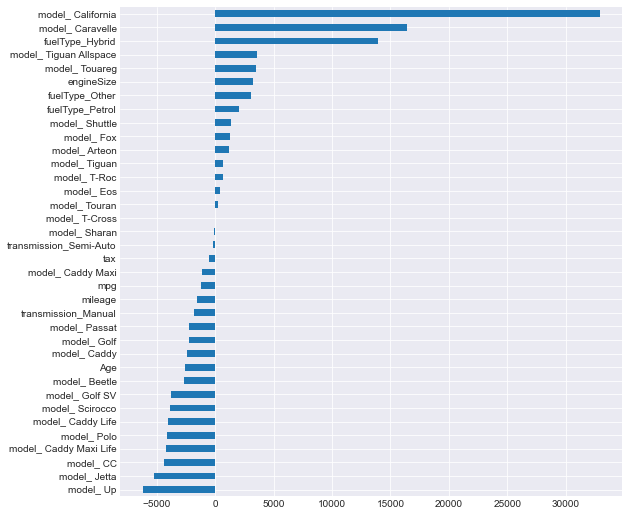

In [44]:
coef = regressor.coef_
coefs = pd.DataFrame(index = x_train_std.columns, 
                     data =coef,columns=['coeficiente'])

coefs.sort_values('coeficiente').plot.barh(figsize=(9,9))
plt.legend("");

# Con la biblioteca 'statsmodels'

Los datos ya se trabajaron las categoricas, se dividio y se estandarizo, para utilizar esta biblioteca es necesario agregar una columna.

In [45]:
X = x_train_std 
Y = y_train

X = sm.add_constant(X) # adding a constant

Teniendo los datos con el formato adecuado, podemos pasar a entrenar el modelo. 

In [46]:
model = sm.OLS(Y, X).fit()

Ya entrenado, se puede hacer las predicciones del modelo, apartir de 'x_test_std'

In [47]:
y_pred_sts = model.predict(sm.add_constant(x_test_std)) 

Podemos revisar todos los datos en un tabla, con el método 'summary'

In [48]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     2708.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:35:35   Log-Likelihood:            -1.1242e+05
No. Observations:               12124   AIC:                         2.249e+05
Df Residuals:                   12087   BIC:                         2.252e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.864e+04    309.132     60.293      0.000     1.8e+04    1.92e+04
mileage                -1597.7572     39.059    -40.906      0.000   -1674.320   -1521.194
tax                     -550.9766     31.239    -17.638      0.000    -612.210    -489.744
mpg                    -1188.2221     40.841    -29.094      0.000   -1268.278   -1108.167
engineSize              3271.2345     53.296     61.379      0.000    3166.766    3375.703
Age                    -2596.7073     39.083    -66.441      0.000   -2673.316   -2520.099
model_ Arteon           1212.8237    346.883      3.496      0.000     532.877    1892.770
model_ Beetle          -2630.1478    435.273     -6.043      0.000   -3483.353   -1776.942
model_ CC              -4402.2589    418.643    -10.516      0.000   -5222.865   -3581.652
model_ Caddy           -2413.7084   1093.117     -2.208      0.027   -4556.392    -271.024
model_ Caddy Life      -4023.6269    958.600     -4.197      0.000   -5902.637   -2144.617
model_ Caddy Maxi      -1162.6098   1520.484     -0.765      0.445   -4143.002    1817.783
model_ Caddy Maxi Life -4193.3975    475.334     -8.822      0.000   -5125.129   -3261.666
model_ California        3.29e+04    830.209     39.631      0.000    3.13e+04    3.45e+04
model_ Caravelle         1.64e+04    411.923     39.822      0.000    1.56e+04    1.72e+04
model_ Eos               415.2763   1522.306      0.273      0.785   -2568.687    3399.239
model_ Fox              1297.1598   1528.470      0.849      0.396   -1698.887    4293.206
model_ Golf            -2261.1638    308.507     -7.329      0.000   -2865.888   -1656.440
model_ Golf SV         -3753.2868    357.227    -10.507      0.000   -4453.508   -3053.065
model_ Jetta           -5222.9651    628.537     -8.310      0.000   -6454.999   -3990.931
model_ Passat          -2251.4587    317.150     -7.099      0.000   -2873.123   -1629.794
model_ Polo            -4152.6009    330.417    -12.568      0.000   -4800.271   -3504.931
model_ Scirocco        -3832.6719    354.452    -10.813      0.000   -4527.454   -3137.889
model_ Sharan           -137.6793    349.357     -0.394      0.694    -822.474     547.116
model_ Shuttle          1344.8211    461.706      2.913      0.004     439.804    2249.838
model_ T-Cross           -56.9295    362.373     -0.157      0.875    -767.238     653.379
model_ T-Roc             635.7011    322.992      1.968      0.049       2.585    1268.817
model_ Tiguan            650.7814    303.390      2.145      0.032      56.088    1245.475
model_ Tiguan Allspace  3544.5422    421.664      8.406      0.000    2718.013    4371.072
model_ Touareg          3523.1773    319.869     11.014      0.000    2896.183    4150.172
model_ Touran            277.7419    342.221      0.812      0.417    -393.065  

### Analisis del performance

Revisemos el performance del modelo

In [49]:
print("Raíz del error cuadrático medio para Audi con statsmodel es :", round(np.sqrt(mean_squared_error(y_test,y_pred_sts)),2))
print('------------------------------------------------------')
err =np.sqrt(mean_squared_error(y_test,y_pred_sts))/ data_vw['price'].mean() *100


print('Teniendo en cuenta que precio promedio es de',round(data_vw['price'].mean(),2),',')
print('el error del modelo es del',round(err,2),'% del precio promedio.')

Raíz del error cuadrático medio para Audi con statsmodel es : 2617.89
------------------------------------------------------
Teniendo en cuenta que precio promedio es de 16839.27 ,
el error del modelo es del 15.55 % del precio promedio.


In [50]:
print("Su métrica R^2 del modelo con statsmodel es: %1.4f" % r2_score(y_test,y_pred_sts))
print('-----------------------------------------')
print('Pero si uso el método de rsquared de la biblioteca da', round(model.rsquared,4),)

Su métrica R^2 del modelo con statsmodel es: 0.8863
-----------------------------------------
Pero si uso el método de rsquared de la biblioteca da 0.8897


Error porcentual promedio 13.13 %


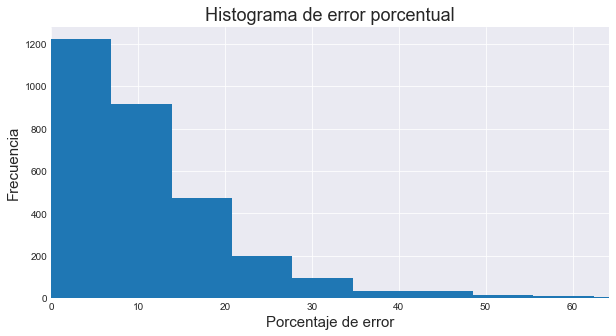

In [51]:
res = abs((y_test - y_pred_sts)/y_test) * 100

plt.figure(figsize = (10,5))

plt.xlim([0, res.quantile(0.99)])
plt.hist(res,bins=100)
plt.xlabel('Porcentaje de error', fontsize = 15)
plt.ylabel('Frecuencia', fontsize = 15)
plt.title('Histograma de error porcentual', fontsize = 18)
print('Error porcentual promedio',round(res.mean(),2),'%');

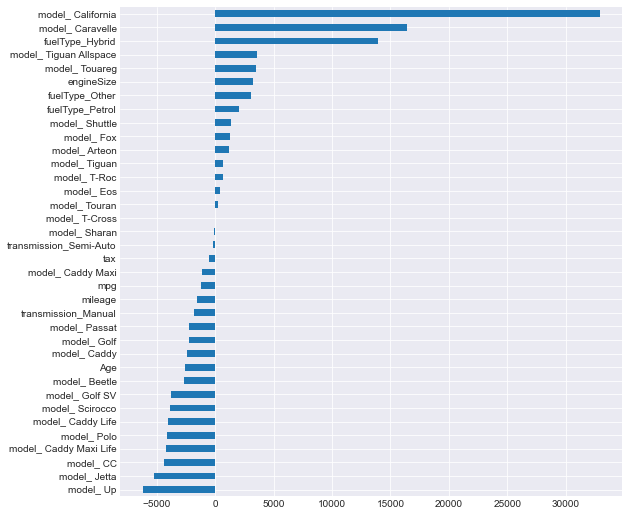

In [52]:
coefs_sts = pd.DataFrame(model.params, columns=['coeficiente'])[1:]

coefs_sts.sort_values('coeficiente').plot.barh(figsize=(9,9))
plt.legend("");

Cabe notar que las variables mas destacadas de nuestro algoritmo son el tipo de modelo (si es California o Jetta), ademas del tipo de combustible (Hybrid) y tamaño del motor (engineSize). La importancia de la ultima variable es un resultado inesperado para mi.  

# ESO DE QUE HÍBRIDO SEA RELEVANTE ESTÁ BIEN RARO PORQUE SOLO EL 1% DE TUS COCHES ERAN HÍBRIDOS

Fue muy importante para el algoritmo los datos del modelo 'California', fue un acierto no eliminar esos valores grandes del precio

Mientras que el kilometraje (mileage) y la antigüedad (Age) no tienen la importancia que yo esperaba.

### No hay diferencia entre las bibliotecas "sklearn" y "statsmodel"

#### Podemos concluir que la regresión lineal tiene un buen performance, con un $R^2$ = 0.886 y un *MSE* que se desvia un 15.5 % del precio promedio. Este modelo se puede perfeccionar si seleccionamos las variables mas significativas para entrenarlo y también podemos probar con otros modelos con el fin de mejorar el performance.

### Mejoramiento del modelo

Revisando que variables son mas importantes, encuentro que los modelos *'T-Cross','Sharan', 'Touran', 'Eos', 'T-Roc' y 'Tiguan'* tienen menor importancia

In [53]:
rev_variables = coefs.sort_values(ascending = True, by='coeficiente')
rev_variables['coef_absoluto'] = abs(coefs['coeficiente'])#/abs(coefs['coeficiente']).max()#*100
rev_variables.sort_values(ascending = True, by='coef_absoluto')[:10]

,coeficiente,coef_absoluto
model_ T-Cross,-56.929543,56.929543
model_ Sharan,-137.679349,137.679349
transmission_Semi-Auto,-196.794452,196.794452
model_ Touran,277.741870,277.741870
model_ Eos,415.276275,415.276275
tax,-550.976572,550.976572
model_ T-Roc,635.701111,635.701111
model_ Tiguan,650.781368,650.781368
model_ Caddy Maxi,-1162.609824,1162.609824
mpg,-1188.222113,1188.222113


Pero al analizar el numero de autos de los seis modelos ('T-Cross','Sharan', 'Touran', 'Eos', 'T-Roc' y 'Tiguan'), vemos que estan dentro de los mas vendidos (con la excepción de Eos), por lo que agruparlo los modelos menos frecuentes **no** nos ayudará a mejorar el performance

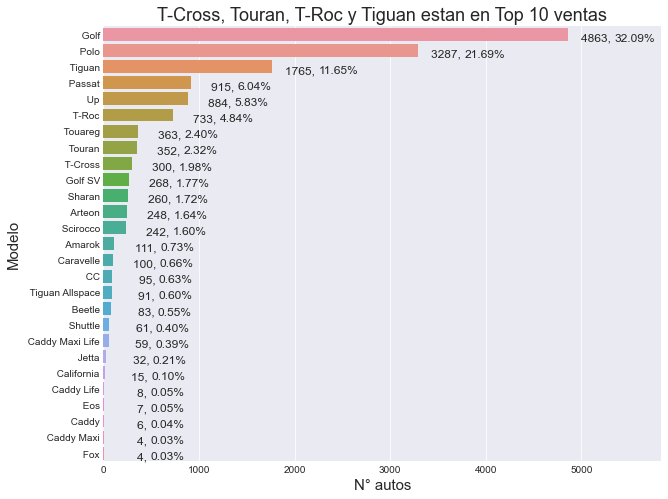

In [54]:
plt.figure(figsize = (10,8))

countplot_values_horizontal(data_vw,"model",12)

plt.title('T-Cross, Touran, T-Roc y Tiguan estan en Top 10 ventas', fontsize = 18)
plt.ylabel('Modelo', fontsize = 15)
plt.xlabel('N° autos', fontsize = 15);

In [46]:
# conteo_auto = data_vw.groupby(['model']).count()[['year']].sort_values(ascending = False, by='year')
# conteo_auto.rename(columns = {'year':'conteo'}, inplace = True)
# conteo_auto['conteo(%)']=conteo_auto['conteo']/conteo_auto['conteo'].sum()*100
# conteo_auto[:12]

Revisando las lista de autos mas caros, se encuentra que el precio de estos modelos estan a la mitad de la lista

In [55]:
precio_auto = data_vw[['model','price']].groupby('model').mean().sort_values(ascending=False, by = 'price')
precio_auto['price'] = round(precio_auto['price'],2)
precio_auto[:15]

,price
model,
California,57593.87
Caravelle,39598.97
Touareg,32882.24
Tiguan Allspace,28770.30
Amarok,27991.50
Arteon,26285.02
Shuttle,24388.15
T-Roc,22839.39
Sharan,22072.95


Por lo que tambien no es una buena idea agrupar los autos por precio, por lo que probare el performance agrupando los 6 modelos en "Otro_modelo"

In [56]:
data_vw['model'].unique()

array([' T-Roc', ' Golf', ' Passat', ' T-Cross', ' Polo', ' Tiguan',
       ' Sharan', ' Up', ' Scirocco', ' Beetle', ' Caddy Maxi Life',
       ' Caravelle', ' Touareg', ' Arteon', ' Touran', ' Golf SV',
       ' Amarok', ' Tiguan Allspace', ' Shuttle', ' Jetta', ' CC',
       ' California', ' Caddy Life', ' Caddy', ' Caddy Maxi', ' Eos',
       ' Fox'], dtype=object)

In [57]:
lista = [' T-Roc', ' T-Cross',  ' Tiguan',
       ' Sharan', ' Touran', ' Eos']

Hago una copia del dataframe y hago el cambio

In [58]:
data_vw2 = data_vw.copy()
data_vw2.replace(to_replace=lista, value = "Otro_modelo", inplace=True)
data_vw2

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company,Age
0,Otro_modelo,2019,25000,Automatic,13904,Diesel,145,49.6,2.0,vw,1
1,Otro_modelo,2019,26883,Automatic,4562,Diesel,145,49.6,2.0,vw,1
2,Otro_modelo,2019,20000,Manual,7414,Diesel,145,50.4,2.0,vw,1
3,Otro_modelo,2019,33492,Automatic,4825,Petrol,145,32.5,2.0,vw,1
4,Otro_modelo,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5,vw,1
...,...,...,...,...,...,...,...,...,...,...,...
15151,Otro_modelo,2012,5990,Manual,74000,Diesel,125,58.9,2.0,vw,8
15152,Fox,2008,1799,Manual,88102,Petrol,145,46.3,1.2,vw,12
15153,Fox,2009,1590,Manual,70000,Petrol,200,42.0,1.4,vw,11
15154,Fox,2006,1250,Manual,82704,Petrol,150,46.3,1.2,vw,14


Declaramos de nuevo las variables

In [59]:
cat = ['model', 'transmission','fuelType']
num = ['mileage', 'tax','mpg', 'engineSize', 'Age']
target = ['price']

 Se trabaja con las variables categóricas y se declara las variables numericas

In [60]:
categories = pd.get_dummies(data_vw2[cat], drop_first = True)
numeric = data_vw2[num];

In [61]:
# categories

Se divide los datos en train y test

In [62]:
predictoras = pd.concat([numeric, categories], axis=1)
objetivo = data_vw2['price']

x_train, x_test, y_train, y_test = train_test_split(predictoras, 
                                                    objetivo, test_size=0.2, random_state = 69)

### Regresión lineal  (modelos de autos agrupados)

estandarizamos las v. numericas, declaramos v. categóricas y armamos los datos de entrenamiento:

In [63]:
x_num = (x_train[num]-x_train[num].mean())/(x_train[num].std())
x_cat = x_train[list(categories.columns)]
x_train_std = pd.concat([x_num, x_cat], axis=1)

Hago lo correspondiente para conjunto de prueba

In [64]:
X_num = (x_test[num]-x_test[num].mean())/(x_test[num].std())
X_cat = x_test[list(categories.columns)]
x_test_std = pd.concat([X_num, X_cat], axis=1)

Entreno el nuevo modelo

In [65]:
regressor = LinearRegression()
regressor.fit(x_train_std, y_train)

y_pred_lr_new = regressor.predict(x_test_std)

Revisemos el performance del modelo

In [66]:
print("Raíz del error cuadrático medio del primer modelo:", round(np.sqrt(mean_squared_error(y_test,y_pred_lr)),2))
print('------------------------------------------------------')
print("Raíz del error cuadrático medio del nuevo modelo:", round(np.sqrt(mean_squared_error(y_test,y_pred_lr_new)),2))

Raíz del error cuadrático medio del primer modelo: 2617.89
------------------------------------------------------
Raíz del error cuadrático medio del nuevo modelo: 2621.94


In [68]:
print("Su métrica R*2 del primer modelo es: %1.4f" % r2_score(y_test,y_pred_lr))
print('------------------------------------------------------')
print("Su métrica R*2 del nuevo modelo es: %1.4f" % r2_score(y_test,y_pred_lr_new))

Su métrica R*2 del primer modelo es: 0.8863
------------------------------------------------------
Su métrica R*2 del nuevo modelo es: 0.8859


Error porcentual promedio 13.11 %


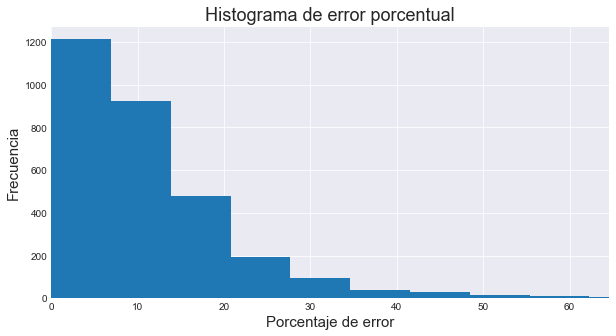

In [69]:
res = abs((y_test - y_pred_lr_new)/y_test) * 100

plt.figure(figsize = (10,5))

plt.xlim([0, res.quantile(0.99)])
plt.hist(res,bins=100)
plt.xlabel('Porcentaje de error', fontsize = 15)
plt.ylabel('Frecuencia', fontsize = 15)
plt.title('Histograma de error porcentual', fontsize = 18)
print('Error porcentual promedio',round(res.mean(),2),'%');

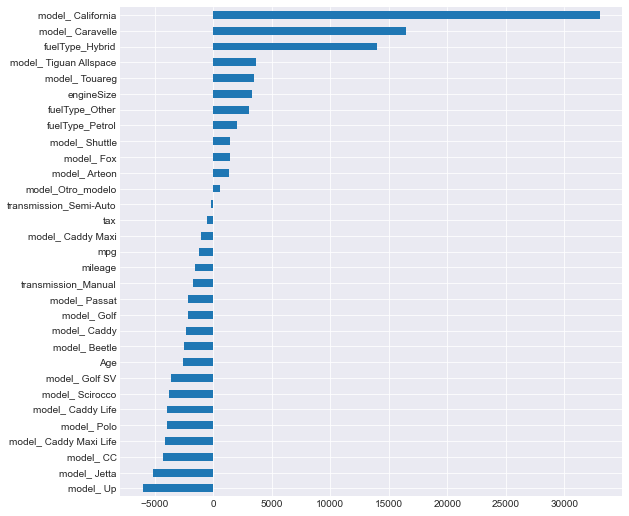

In [70]:
coef = regressor.coef_
coefs = pd.DataFrame(index = x_train_std.columns, 
                     data =coef,columns=['coeficiente'])

coefs.sort_values('coeficiente').plot.barh(figsize=(9,9))
plt.legend("");

**El modelo no mejoro al agrupar los 6 seis modelos, incluso disminuyo ligeramente su performance en el error cuadratico medio y R**2**

# Para la compañia Audi 

## Parte 1:  Analisis exploratorio

In [71]:
data_audi = li[0]
data_audi

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0,audi
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0,audi
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0,audi
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4,audi


Creamos la columna "Age" 

In [72]:
data_audi['Age']= 2020 - data_audi['year']

data_audi

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company,Age
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,audi,3
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,audi,4
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,audi,4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,audi,3
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,audi,1
...,...,...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0,audi,0
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0,audi,0
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0,audi,0
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4,audi,3


Revisemos valores nulos

In [73]:
desc_inicial(data_audi)

Sus dimensiones son: 10668 renglones y 11 columnas.
-----------------------------
Los valores nulos son:


model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
Company         0
Age             0
dtype: int64

No hay valores nulos

Se hace el histograma de precios

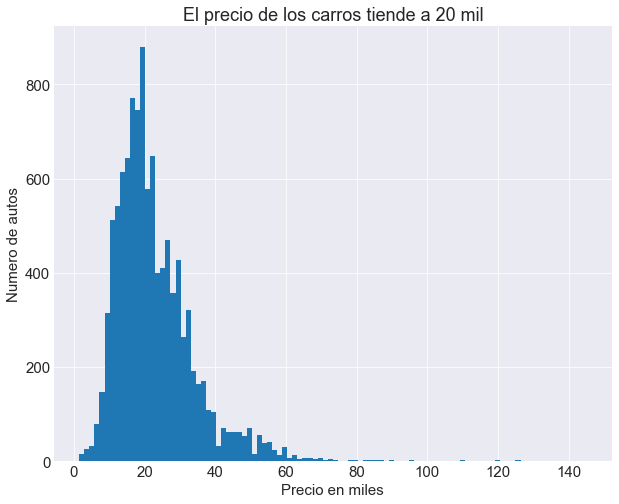

In [76]:
plt.figure(figsize = (10,8))

(data_audi['price']/1000).hist(bins = 100)
plt.title('El precio de los carros tiende a 20 mil',fontsize = 18)

# plt.xlim(0 , data_vw['price'].quantile(0.99));
plt.xlabel('Precio en miles', fontsize = 15)
plt.ylabel('Numero de autos', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);

### Precio vs Antigüedad

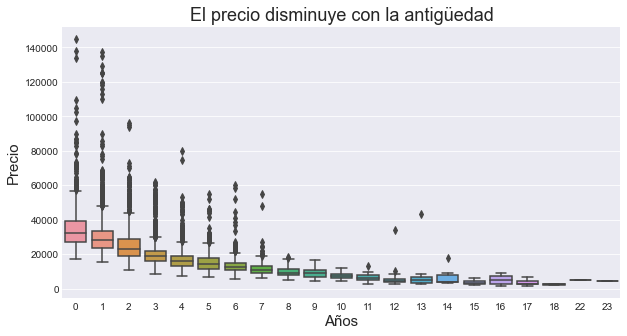

In [77]:
plt.figure(figsize = (10,5))

# sbn.set(style="darkgrid")
sbn.boxplot(x = data_audi['Age'], y = data_audi['price'])

plt.title('El precio disminuye con la antigüedad', fontsize = 18)
plt.xlabel('Años', fontsize = 15)
plt.ylabel('Precio', fontsize = 15)
plt.xticks(rotation= 0);

### Year vs N° de autos

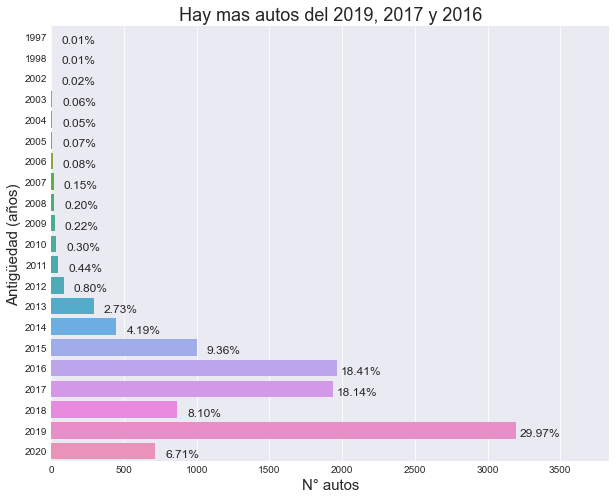

In [78]:
plt.figure(figsize = (10,8))

data = data_audi
column = 'year'
size = 12

ax = sbn.countplot(y = data[column])#, order = data[column].value_counts().index)
        
total_col = data[column].value_counts().sum()
max_val = max(data[column].value_counts())
mean_val = data[column].value_counts().mean()
ax.set_xlim([0,1.2*max_val])

for i, j in enumerate((data.groupby(column).count()['model'])):
#     plt.text(j+0.6*mean_val, i+0.4, "%d, " % j, fontsize=size,ha='right'); # ha -> posicion de la etiqueta
    plt.text(j+0.6*mean_val, i+0.3, "%.2f%%" % round(j/total_col*100,2), fontsize=size,  ha='right')# ha='left')

plt.title('Hay mas autos del 2019, 2017 y 2016', fontsize=18)
plt.ylabel('Antigüedad (años)', fontsize = 15)
plt.xlabel('N° autos', fontsize = 15);

### Tipo de transmisión y combustible 

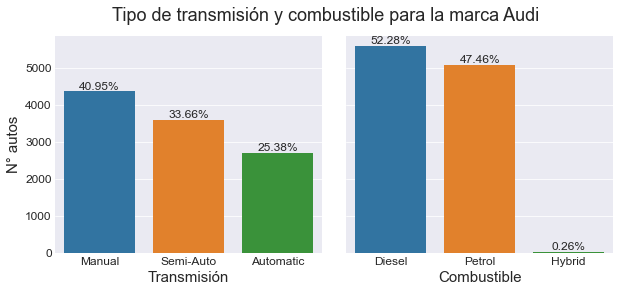

In [81]:
plt.figure(figsize = (10,4))
plt.suptitle('Tipo de transmisión y combustible para la marca Audi', fontsize= 18)

#-------------------------------
ax1 = plt.subplot2grid(shape=(1,4), loc=(0,0), colspan=2)

countplot_values(data_audi,"transmission",12)
    
plt.title('',fontsize= 16)
plt.xlabel('Transmisión',fontsize= 15)
plt.ylabel('N° autos', fontsize= 15)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)

#----------------------------------------
ax2 = plt.subplot2grid((1,4), (0,2), colspan=2, sharey = ax1)

countplot_values(data_audi,"fuelType",12)

# Poner titulo, nombres de ejes,    
plt.title('',fontsize= 16)
plt.xlabel('Combustible',fontsize= 15)
plt.ylabel('', fontsize= 15)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12);

for label2 in ax2.get_yticklabels():
    label2.set_visible(False)

plt.show()

### Modelos de auto

In [82]:
data_audi.groupby('model').count()['year'].max()

1929

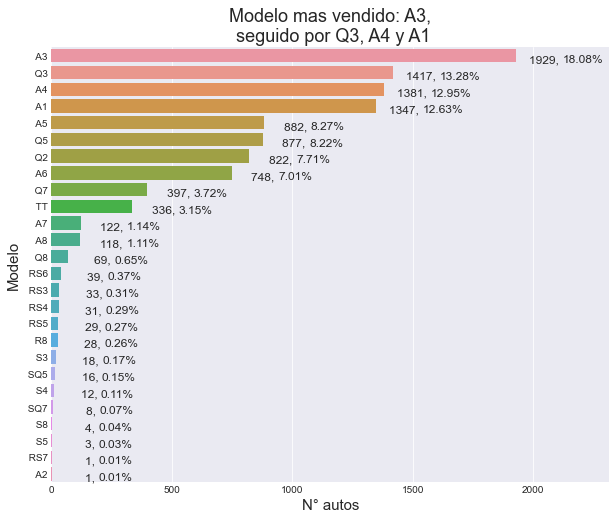

In [83]:
plt.figure(figsize = (10,8))

countplot_values_horizontal(data_audi,"model",12)

# plt.xlim([0,1.25*data_audi.groupby('model').count()['year'].max()])
plt.title('Modelo mas vendido: A3,\n seguido por Q3, A4 y A1', fontsize = 18)
plt.ylabel('Modelo', fontsize = 15)
plt.xlabel('N° autos', fontsize = 15);

Por ultimo revisemos las correlaciones

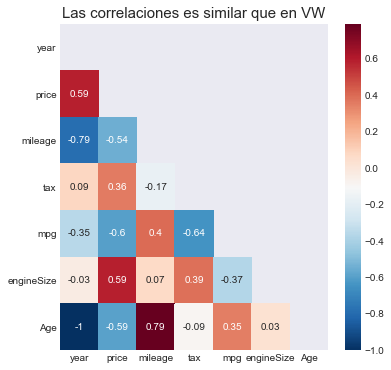

In [84]:
corr = data_audi.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(6,6));
plt.title('Las correlaciones es similar que en VW', fontsize = 15)

sbn.heatmap(corr.round(decimals=2), annot= True, cmap = "RdBu_r", mask = mask);

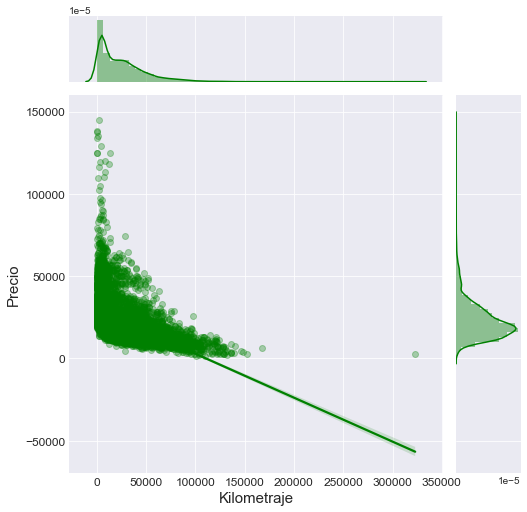

In [85]:
sbn.jointplot(data_audi['mileage'], data_audi['price'], kind = 'reg', 
              color = 'g', height = 7, 
              scatter_kws=dict(alpha=0.3))

plt.xlabel('Kilometraje', fontsize = 15)
plt.ylabel('Precio', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

Se identifica el outlier, tiene un precio alto considerando que tiene un gran kilometraje

In [86]:
data_audi[(data_audi['mileage']>300000)]

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Company,Age
9822,A6,2008,2490,Manual,323000,Diesel,200,44.1,2.0,audi,12


Se quita el outlier del dataframe y se gráfica para confirmar que se haya eliminado

In [87]:
data_audi = data_audi.drop(data_audi[(data_audi['mileage']> 300000)].index).reset_index(drop = True) 

Revisemos que ya no esta el outlier

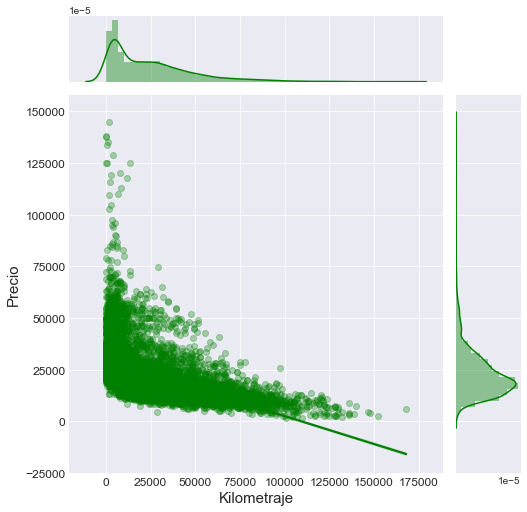

In [88]:
sbn.jointplot(data_audi['mileage'], data_audi['price'], kind = 'reg', 
              color = 'g', height = 7, 
              scatter_kws=dict(alpha=0.3))

plt.xlabel('Kilometraje', fontsize = 15)
plt.ylabel('Precio', fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

### Parte 2: Modelación

In [89]:
cat = ['model', 'transmission','fuelType']
num = ['mileage', 'tax','mpg', 'engineSize', 'Age']
target = ['price']

categories = pd.get_dummies(data_audi[cat], drop_first = True)
numeric = data_audi[num];

In [90]:
predictoras = pd.concat([numeric, categories], axis=1)
objetivo = data_audi['price']

x_train, x_test, y_train, y_test = train_test_split(predictoras, 
                                                    objetivo, test_size=0.2, random_state = 69)

estandarizamos y armamos los datos de entrenamiento:

In [91]:
x_num = (x_train[num]-x_train[num].mean())/(x_train[num].std())
x_cat = x_train[list(categories.columns)]
x_train_std = pd.concat([x_num, x_cat], axis=1)

Hago lo correspondiente para conjunto de prueba

In [92]:
X_num = (x_test[num]-x_test[num].mean())/(x_test[num].std())
X_cat = x_test[list(categories.columns)]
x_test_std = pd.concat([X_num, X_cat], axis=1)

Entreno el modelo con los datos completos:

In [93]:
regressor = LinearRegression()
regressor.fit(x_train_std, y_train)

y_pred_lr_audi = regressor.predict(x_test_std)

### Analisis del performance

Revisemos el performance del modelo

In [94]:
print("Raíz del error cuadrático medio para Audi es :", round(np.sqrt(mean_squared_error(y_test,y_pred_lr_audi)),2))
print('------------------------------------------------------')
err =np.sqrt(mean_squared_error(y_test,y_pred_lr_audi))/ data_audi['price'].mean() *100


print('Teniendo en cuenta que precio promedio es de',round(data_audi['price'].mean(),2),',')
print('el error del modelo es del',round(err,2),'% del precio promedio.')

Raíz del error cuadrático medio para Audi es : 3939.6
------------------------------------------------------
Teniendo en cuenta que precio promedio es de 22898.6 ,
el error del modelo es del 17.2 % del precio promedio.


In [95]:
print("Su métrica R^2 del nuevo modelo es: %1.4f" % r2_score(y_test,y_pred_lr_audi))

Su métrica R^2 del nuevo modelo es: 0.8898


Error porcentual promedio 12.74 %


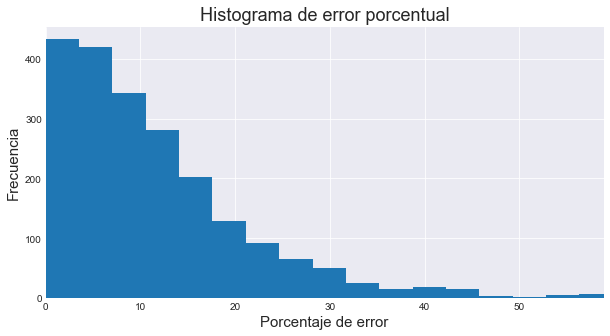

In [96]:
res = abs((y_test - y_pred_lr_audi)/y_test) * 100

plt.figure(figsize = (10,5))

plt.xlim([0, res.quantile(0.99)])
plt.hist(res,bins=100)
plt.xlabel('Porcentaje de error', fontsize = 15)
plt.ylabel('Frecuencia', fontsize = 15)
plt.title('Histograma de error porcentual', fontsize = 18)
print('Error porcentual promedio',round(res.mean(),2),'%');

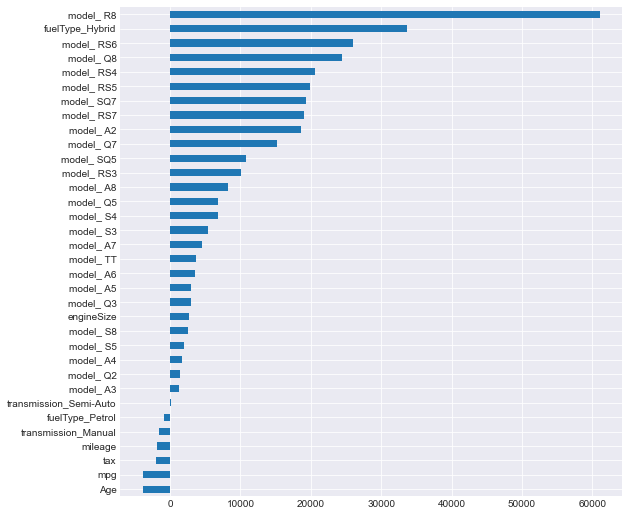

In [97]:
coef = regressor.coef_
coefs = pd.DataFrame(index = x_train_std.columns, 
                     data =coef,columns=['coeficiente'])

coefs.sort_values('coeficiente').plot.barh(figsize=(9,9))
plt.legend("");

Se puede ver que el tipo de combustible Hybrid tiene una gran importancia en el modelo, ademas del tipo modelo  y el tamaño de motor (engineSize)

**Ambos modelos, para VW y Audi, muestran un performarce similar, que es bastante bueno pero puede mejorar si se utiliza otro modelo ademas de LinearRegressor**

**El modelo del auto es importante (como era de esperarse), pero el tipo de combustible y el tamaño del motor tienen una gran importancia no esperada por mi, mientras que el kilometraje no tiene el impacto esperado en el modelo**

# Con la biblioteca 'statsmodels'

Los datos ya se trabajaron las categoricas, se dividio y se estandarizo, para utilizar esta biblioteca es necesario agregar una columna.

In [98]:
X = x_train_std 
Y = y_train

X = sm.add_constant(X) # adding a constant

Teniendo los datos con el formato adecuado, podemos pasar a entrenar el modelo. 

In [99]:
model = sm.OLS(Y, X).fit()

Ya entrenado, se puede hacer las predicciones del modelo, apartir de 'x_test_std'

In [100]:
y_pred_sts = model.predict(sm.add_constant(x_test_std)) 

Podemos revisar todos los datos en un tabla, con el método 'summary'

In [101]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     2070.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        09:47:44   Log-Likelihood:                -82514.
No. Observations:                8533   AIC:                         1.651e+05
Df Residuals:                    8498   BIC:                         1.653e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.041e+04    189.782    107.540      0.000       2e+04    2.08e+04
mileage                -1893.5019     72.386    -26.158      0.000   -2035.397   -1751.607
tax                    -1942.3407     61.157    -31.760      0.000   -2062.224   -1822.458
mpg                    -3796.5204     93.758    -40.493      0.000   -3980.309   -3612.732
engineSize              2627.5810     82.841     31.718      0.000    2465.193    2789.969
Age                    -3842.3076     72.658    -52.882      0.000   -3984.736   -3699.880
model_ A2               1.863e+04   3857.131      4.831      0.000    1.11e+04    2.62e+04
model_ A3               1298.1922    159.678      8.130      0.000     985.185    1611.199
model_ A4               1665.7916    186.864      8.914      0.000    1299.492    2032.091
model_ A5               3024.3820    213.398     14.172      0.000    2606.070    3442.694
model_ A6               3586.9631    235.028     15.262      0.000    3126.251    4047.675
model_ A7               4587.4760    448.914     10.219      0.000    3707.496    5467.456
model_ A8               8265.0657    460.527     17.947      0.000    7362.321    9167.810
model_ Q2               1354.1066    206.116      6.570      0.000     950.068    1758.145
model_ Q3               2919.6493    187.815     15.545      0.000    2551.487    3287.812
model_ Q5               6869.4805    240.380     28.578      0.000    6398.277    7340.684
model_ Q7                1.52e+04    339.586     44.770      0.000    1.45e+04    1.59e+04
model_ Q8               2.438e+04    596.212     40.896      0.000    2.32e+04    2.56e+04
model_ R8               6.101e+04    963.127     63.347      0.000    5.91e+04    6.29e+04
model_ RS3              1.011e+04    826.652     12.232      0.000    8491.291    1.17e+04
model_ RS4               2.06e+04    819.302     25.146      0.000     1.9e+04    2.22e+04
model_ RS5              1.985e+04    794.793     24.980      0.000    1.83e+04    2.14e+04
model_ RS6              2.598e+04    757.919     34.272      0.000    2.45e+04    2.75e+04
model_ RS7              1.904e+04   3869.080      4.922      0.000    1.15e+04    2.66e+04
model_ S3               5385.8763   1120.727      4.806      0.000    3188.979    7582.773
model_ S4               6781.5477   1242.385      5.458      0.000    4346.171    9216.924
model_ S5               2038.5446   2729.050      0.747      0.455   -3311.057    7388.146
model_ S8               2551.3654   2246.272      1.136      0.256   -1851.873    6954.604
model_ SQ5              1.084e+04   1087.640      9.965      0.000    8705.816     1.3e+04
model_ SQ7              1.933e+04   1400.686     13.803      0.000    1.66e+04    2.21e+04
model_ TT               3720.9657    276.479     13.458      0.000    3178.999  

### Analisis del performance

Revisemos el performance del modelo

In [102]:
print("Raíz del error cuadrático medio para Audi con statsmodel es :", round(np.sqrt(mean_squared_error(y_test,y_pred_sts)),2))
print('------------------------------------------------------')
err =np.sqrt(mean_squared_error(y_test,y_pred_sts))/ data_audi['price'].mean() *100


print('Teniendo en cuenta que precio promedio es de',round(data_audi['price'].mean(),2),',')
print('el error del modelo es del',round(err,2),'% del precio promedio.')

Raíz del error cuadrático medio para Audi con statsmodel es : 3939.6
------------------------------------------------------
Teniendo en cuenta que precio promedio es de 22898.6 ,
el error del modelo es del 17.2 % del precio promedio.


In [103]:
print("Su métrica R^2 del modelo con statsmodel es: %1.4f" % r2_score(y_test,y_pred_sts))
print('-----------------------------------------')
print('Pero si uso el método de rsquared de la biblioteca da', round(model.rsquared,4),)

Su métrica R^2 del modelo con statsmodel es: 0.8898
-----------------------------------------
Pero si uso el método de rsquared de la biblioteca da 0.8923


Error porcentual promedio 12.74 %


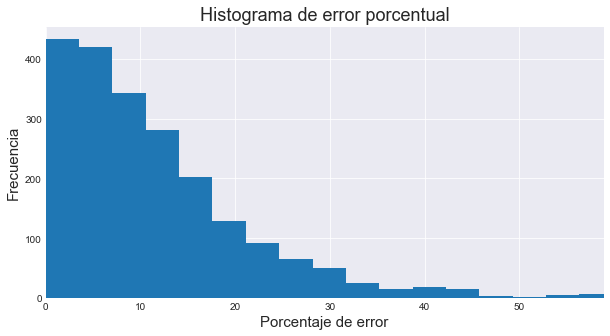

In [104]:
res = abs((y_test - y_pred_sts)/y_test) * 100

plt.figure(figsize = (10,5))

plt.xlim([0, res.quantile(0.99)])
plt.hist(res,bins=100)
plt.xlabel('Porcentaje de error', fontsize = 15)
plt.ylabel('Frecuencia', fontsize = 15)
plt.title('Histograma de error porcentual', fontsize = 18)
print('Error porcentual promedio',round(res.mean(),2),'%');

(34, 1)

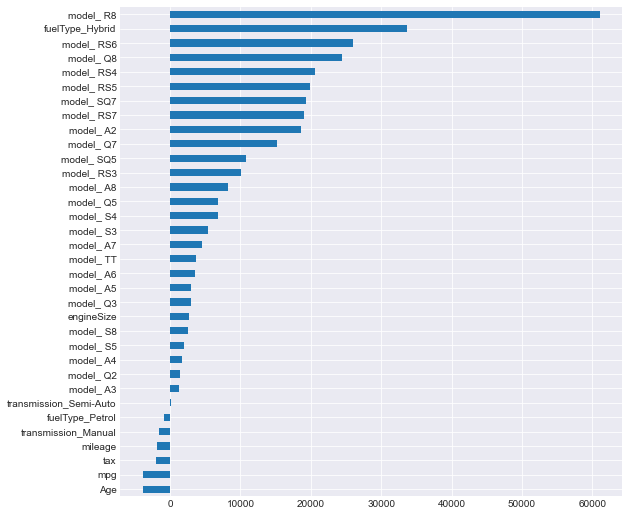

In [105]:
coefs_sts = pd.DataFrame(model.params, columns=['coeficiente'])[1:]

coefs_sts.sort_values('coeficiente').plot.barh(figsize=(9,9))
plt.legend("");
coefs.shape

### Como vimos con el modelo de VW, no hay diferencia clara entre los resultados de las bibliotecas 'sklearn' y 'statsmodel'